# Определение возраста покупателей по фото

## Цель проекта

Необходимо построить модель, определяющую приблизительный возраст человека по фотографии, с максимально допустимым отклонением в 8 лет. Модель разрабатывается для использования в сетевом супермаркете; определение возраста покупателя с помощью модели позволит:

- улучшить анализ покупательского поведения, усовершенствовать систему рекомендаций товаров для различных возрастных групп;
- усилить систему контроля за продажами алкоголя и табачной продукции. 

Данные для обучения модели представлены набором фотографий с размеченным реальным возрастом человека на фото.

Для реализации поставленной задачи следует:
- Проанализировать исходные данные (возрастная структура, особенности фотографий и т.п.);
- Подготовить данные к анализу (масштабирование, аугментации и т.п.);
- Выбрать архитектуру модели;
- Обучить модель и оценить ее качество. Метрикой качества, по требованию заказчика, выбран показатель *MAE*.

## Исследовательский анализ данных

Исходные данные состоят из двух частей:
 - пула фотографий,
 - файла-мэппинга, соотносящего название файла и реальный возраст человека на данном фото.
 
 Для начала рассмотрим общую информацию о мэппинг-файле.

In [1]:
# Импорты используемых библиотек:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Общая информация о мэппинг-файле: 
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.info())

labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Предоставленный набор данных содержит ок. 7.6 тыс. изображений. Пропуски в разметке возраста отсутствуют. Проверим данные на дубликаты: как полное совпадение (название файла <-> возраст), так и на задвоения названий файлов:

In [3]:
print('Количество полных дубликатов:', labels.duplicated().sum())
print('Количество дубликатов в названиях файлов:', labels['file_name'].duplicated().sum())

Количество полных дубликатов: 0
Количество дубликатов в названиях файлов: 0


Дубликаты в данных отсутствуют.

Рассмотрим распределение людей в выборке по возрастам:

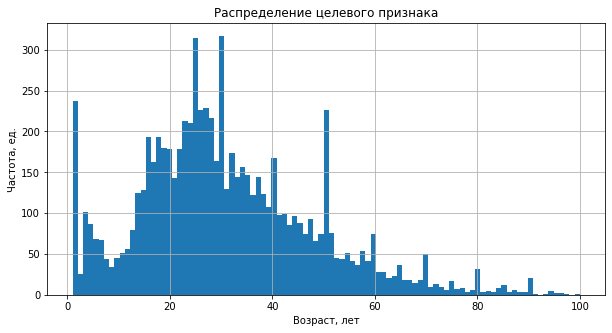

In [4]:
labels.hist(bins=97, figsize=(10, 5))
plt.title('Распределение целевого признака')
plt.xlabel('Возраст, лет')
plt.ylabel('Частота, ед.')
plt.show()

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Распределение смещено вправо: медиана составляет 29 лет при среднем в 31 год. Присутствуют всплески на уровне 1 года, 25, 30, 40 и 50 лет. При этом есть провал на интервале 7-15 лет, что может повлиять на качество модели (слишком мало фото для этой возрастной категории). Максимальный возраст в выборке составляет 100 лет.

Рассмотрим примеры изображений в выборке:

Found 7591 validated image filenames.


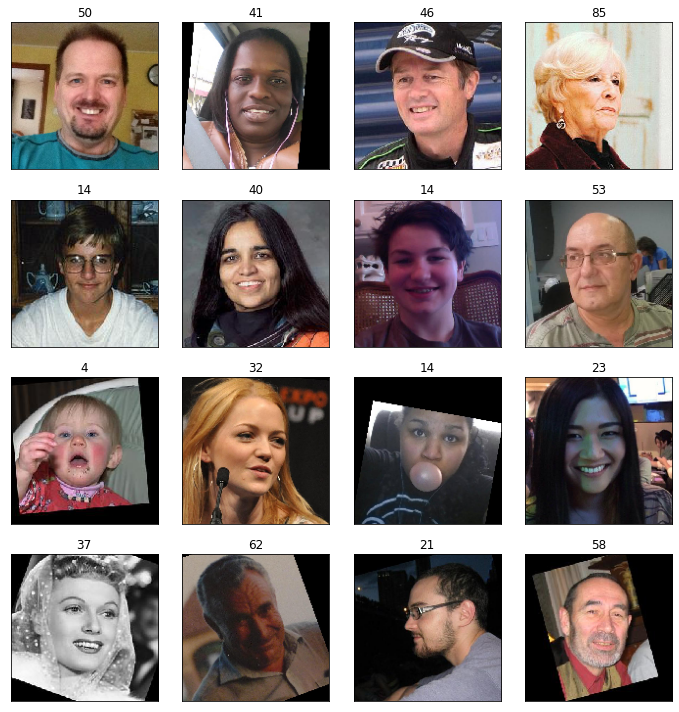

In [6]:
# Определяем загрузчик изображений:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        seed=12345) 
# Загружаем первый батч:
sample, target_sample = next(train_gen_flow)
# Визуализируем первые 16 изображений:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(sample[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target_sample[i])
    plt.tight_layout()

- В датасете присутствуют как цветные, так и черно-белые фотографии;
- Часть фотографий развернута так, чтобы лицо было расположено вертикально;
- Скорее всего, фотограции центрированы (лицо расположено в центре);
- Фотографии необязательно сделаны анфас: есть фото в профиль, с частичным поворотом/наклоном головы;
- На фото на уровне лица могут присутствовать посторонние предметы (микрофон, жвачка и т.п.).

Данные отлично подходят для поставленной задачи: фотофиксация в прикассовой зоне скорее всего позволит получить только частичное изображение лица (с наклоном, поворотом головы, помехами на лице и т.п.)

**Вывод**

Исходные данные представлены массивом из ок. 7,6 фото c указанием возраста. Дубликаты и пропуски в разметке отсутствуют. В выборке преобладают люди от 20 до 41 года (50% от общего числа объектов). При этом фиксируется провал в возрастном распределении на интерване 7-15 лет. Также присутствуют всплески на уровне 1 года, 25, 30, 40 и 50 лет. Такие "неровности" могут ухудшить качество модели. 

Фотографии представлены как в монохроме, так и в цвете; люди изображены в максимально естественных позах: с поворотами/наклонами головы, с помехами на лице (очки, волосы и т.д.), а также посторонними предметами на уровне лица. Обученная на такой выборке модель будет способна предсказывать возраст на основании реальных снимков с камер наблюдения супермаркетов. 

Тем не менее, фотографии, скорее всего, были обработаны заранее для распознавания лица из общего снимка. Это отдельная задача, выходящая за рамки данного проекта.

## Обучение модели

Для предсказания возраста по фото воспользуемся архитектурой ResNet50 с модификацией полносвязных слоев. Используем два полносвязных слоя: скрытый слой из 10 нейронов (активация ReLU) и выходной слой из одного нейрона (активация ReLU). Таким образом на выходе получится взвешенная оценка возраста. В качестве функции потерь используем *MSE* для ускорения обучения.

Также введем аугментации в обучающую выборку для улучшения качества модели. Вертикальное отображение едва ли существенно улучит обучаемость модели (лица условно-симметричны по вертикальной оси); поэтому используем горизонтальное отражение. Кроме того, данные должны быть масштабированы в обеих выборках.

```python
# Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import pandas as pd

# Подготовка обучающей выборки:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                horizontal_flip=True,      # добавление аугментаций
                                rescale = 1./255)          # масштабирование
    train_gen_flow = datagen.flow_from_dataframe( 
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow

# Подготовка валидационной выборки:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                rescale = 1./255)          # только масштабирование
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow

# Определение архитектуры модели:
def create_model(input_shape):
    opt = Adam(learning_rate=0.0001)                      # параметр подобран экспериментально
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',               # инициализируем веса предобученной модели
                        include_top=False)                # исключаем "верхушку" классической архитектуры
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

    return model


# Обучение модели:
def train_model(model, train_data, test_data, batch_size=None, epochs=7,  # число эпох подобрано экспериментально
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

Результат обучения модели:
```
<...>
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<...>
Train for 356 steps, validate for 119 steps
Epoch 1/7
<...>
356/356 - 53s - loss: 199.2890 - mae: 10.3689 - val_loss: 697.1788 - val_mae: 21.2645
Epoch 2/7
356/356 - 42s - loss: 82.0649 - mae: 6.9095 - val_loss: 148.6581 - val_mae: 9.6304
Epoch 3/7
356/356 - 43s - loss: 54.8152 - mae: 5.6709 - val_loss: 95.1613 - val_mae: 7.2270
Epoch 4/7
356/356 - 43s - loss: 40.8192 - mae: 4.8677 - val_loss: 82.0525 - val_mae: 6.7640
Epoch 5/7
356/356 - 43s - loss: 32.1499 - mae: 4.3200 - val_loss: 75.1889 - val_mae: 6.6258
Epoch 6/7
356/356 - 42s - loss: 24.6412 - mae: 3.8047 - val_loss: 83.4374 - val_mae: 6.7145
Epoch 7/7
356/356 - 42s - loss: 20.8942 - mae: 3.4579 - val_loss: 68.1786 - val_mae: 6.0642
<...>
119/119 - 10s - loss: 68.1786 - mae: 6.0642
Test MAE: 6.0642
```

**Вывод**

Модель с означенной архитектурой обучется относительно быстро (за счет небольшого количества объектов в выборке). Качество модели стабильно выше порогового значения в 8 лет (начиная с третьей эпохи; значения *MAE* на валидации (6.7 - 6.0) значимо отличаются от порогового). Заметно переобучение модели: разрыв между качеством модели на обучающей и тестовой выборках растет по мере обучения, начиная с 4 эпохи. Тем не менее, результат на тестовых данных стабилен, поэтому модель можно использовать в работе.

## Общий вывод

Цель проекта состояла в построении модели, определяющей возраст человека по фото, для улучшения работы сетевого супермаркета. Исходные данные представляли собой ок. 7,6 тыс. изображений и мэппинг-файла с названием изображения и отметкой о реальном возрасте человека на фото. Пропуски или дубликаты в данных не обнаружены.

Возрастное распределение несколько смещено; присутствуют провал на интервале в 7-15 лет и всплески в распределении на уровне 1 года, 25, 30, 40 и 50 лет. Т.е. выборка может оказаться недостаточно репрезентативной для определения подростков. Лица зафиксированы в естестенных позах, с помехами (волосы, очки) и посторонними предметами, что соответсвует предполагаемым входным данным при работе модели (снимки с камер). Тем не менее, исходный датасет, скорее всего, предоставляет собой результат отдельного процесса по распознаванию лица из общего кадра (за рамками текущего проекта); соответственно, снимки с камер необходимо будет предобрадатывать для корректной работы модели.

Исходные данные были масштабированы; в обучающую выборку добавлены аугментации для улучшения качества модели.

Для определения возраста по фото была выбрана архитектура сети ResNet50 с кастомизированным завершением (был использован скрытый полносвязный слой в 10 нейронов для получения взвешенной оценки возраста). Качество модели по метрике *MAE* составило 6.06, что выше заданного порогового значения в 8 лет.

Предложенную модель можно успешно использовать для определения возрастной когорты покупателей и улучшения рекомендаций предлагаемых товаров. Однако эффективность использования для фиксации нарушений при продаже алкоголя/табачной продукции сомнительна из-за погрешности определения возраста в 6 лет. Возможно, для контроля возрастных ограничений следует отправлять на ручное рассмотрение сомнительные случаи, либо использовать дополнительные алгоритмы по распознаванию документа в кадре и т.п.  